In [1]:
import numpy as np
import cv2

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from skimage.color import rgb2lab, lab2rgb

In [737]:
img = cv2.imread('ooyy.jpg')
img_resized = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB) / 255.

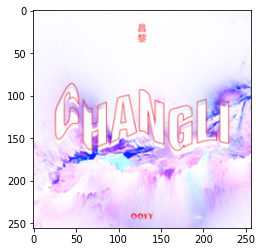

In [738]:
plt.imshow(img_rgb)

In [739]:
average = img_rgb.mean(axis=0).mean(axis=0)
print(average)

[0.94117085 0.88691263 0.97902976]


In [740]:
average_img = np.ones([100,100,3]) * average

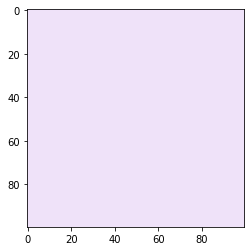

In [741]:
plt.imshow(average_img)

In [742]:
# def rgb_to_chroma(red, green, blue):
#     alpha = 0.5*(2*red - green - blue)
#     betha = (np.sqrt(3)/2)*(green - blue)

#     H2 = np.arctan2(betha, alpha)
#     G2 = np.sqrt(alpha**2 + betha**2)
#     I = (red + green + blue)/3
#     return H2, G2, I

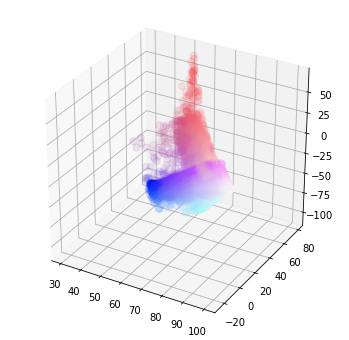

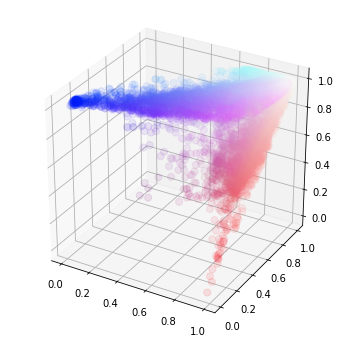

In [743]:
red = img_rgb[:,:,0].flatten()
green = img_rgb[:,:,1].flatten()
blue = img_rgb[:,:,2].flatten()
colors = list(zip(red, green, blue))

img_hsv = rgb_to_hsv(img_rgb)
H = img_hsv[:,:,0].flatten()
S = img_hsv[:,:,1].flatten()
V = img_hsv[:,:,2].flatten()

img_lab = rgb2lab(img_rgb)
L = img_lab[:,:,0].flatten()
A = img_lab[:,:,1].flatten()
B = img_lab[:,:,2].flatten()

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, polar=True)
# ax.scatter(H, S, color=colors, s=200, marker=".", cmap='hsv')

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L, A, B, color=colors, s=200, marker=".", cmap='rgb', alpha=0.1)
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(red, green, blue, color=colors, s=200, marker=".", cmap='rgb', alpha=0.1)
plt.show()

In [744]:
from sklearn.cluster import KMeans

In [745]:
N_CLUSTERS = 10

X_lab = list(zip(L, A, B))
clusters_lab = KMeans(n_clusters=N_CLUSTERS).fit(X_lab)
xs, ys, zs = (clusters_lab.cluster_centers_.T[0], clusters_lab.cluster_centers_.T[1], clusters_lab.cluster_centers_.T[2])

In [746]:
clusters_rgb = lab2rgb(np.array(clusters_lab.cluster_centers_).reshape([N_CLUSTERS,1,3])).reshape(N_CLUSTERS,3)
clusters_colors = list(zip(clusters_rgb.T[0], clusters_rgb.T[1], clusters_rgb.T[2]))

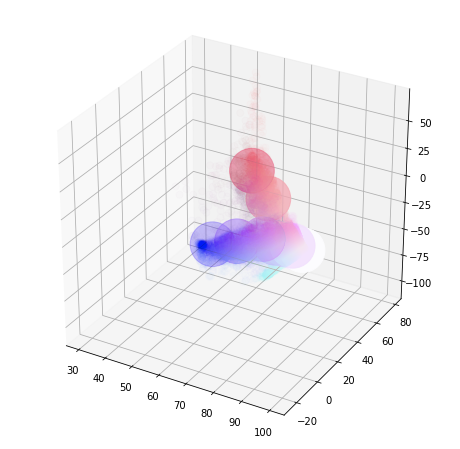

In [747]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L, A, B, color=colors, s=200, marker=".", cmap='rgb', alpha=0.01)

ax.scatter(xs, ys, zs, color=clusters_colors, cmap='rgb', s=2000, marker="o")
plt.show()

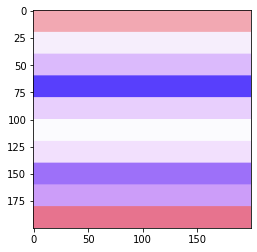

In [748]:
clusters_img = np.ones([20*N_CLUSTERS,20*N_CLUSTERS,3])
for i in range(N_CLUSTERS):
    begin = i*20
    end = (i+1)*20
    clusters_img[begin:end,:] = clusters_rgb[i]
plt.imshow(clusters_img)

In [749]:
def colorfulness(r, g, b):
    """Returns a colorfulness index of given RGB combination.
    Implementation of the colorfulness metric proposed by
    Hasler and Süsstrunk (2003) in https://infoscience.epfl.ch/
    record/33994/files/HaslerS03.pdf.
    Args:
        r (int): Red component.
        g (int): Green component.
        b (int): Blue component.
    Returns:
        float: Colorfulness metric.
    """
    rg = np.absolute(r - g)
    yb = np.absolute(0.5 * (r + g) - b)

    # Compute the mean and standard deviation of both `rg` and `yb`.
    rg_mean, rg_std = (np.mean(rg), np.std(rg))
    yb_mean, yb_std = (np.mean(yb), np.std(yb))

    # Combine the mean and standard deviations.
    std_root = np.sqrt((rg_std ** 2) + (yb_std ** 2))
    mean_root = np.sqrt((rg_mean ** 2) + (yb_mean ** 2))

    return std_root + (0.3 * mean_root)

In [750]:
clusters_rgb = sorted(clusters_rgb, key=lambda color: colorfulness(*color), reverse=True)
clusters_rgb_filtered = list(filter(lambda color: colorfulness(*color) > 0.05, clusters_rgb))
N_CLUSTERS_FILTERED = len(clusters_rgb_filtered)

if (N_CLUSTERS_FILTERED == 0):
    clusters_rgb_filtered.append(clusters_rgb[0])
    N_CLUSTERS_FILTERED = 1


best_color1 = clusters_rgb_filtered[(N_CLUSTERS_FILTERED-1)//2]

if (N_CLUSTERS_FILTERED > 1):
    best_color2 = clusters_rgb_filtered[(N_CLUSTERS_FILTERED-1)//2+1]
else:
    best_color2 = best_color1

if (abs(colorfulness(*best_color1)-colorfulness(*best_color2)) > 0.05):
    best_color = best_color1*0.5 + best_color2*0.5
else:
    best_color = best_color1
    
print(abs(colorfulness(*best_color1)-colorfulness(*best_color2)))

0.04487213378077083


In [751]:
colorfulness_img = np.ones([512,512,3]) * best_color
colorfulness_img[30:286,30:286] = img_rgb

averagecolor_img = np.ones([512,512,3]) * (average)
averagecolor_img[30:286,30:286] = img_rgb

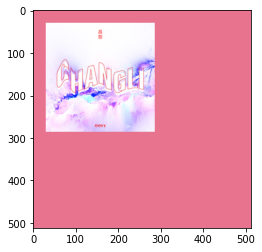

In [752]:
plt.imshow(colorfulness_img)

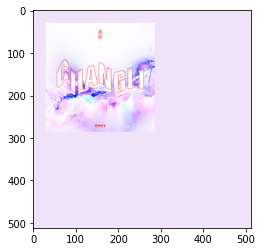

In [753]:
plt.imshow(averagecolor_img)

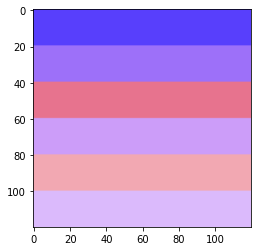

In [754]:
clusters_img = np.ones([20*N_CLUSTERS_FILTERED,20*N_CLUSTERS_FILTERED,3])
for i in range(N_CLUSTERS_FILTERED):
    begin = i*20
    end = (i+1)*20
    clusters_img[begin:end,:] = clusters_rgb_filtered[i]
plt.imshow(clusters_img)

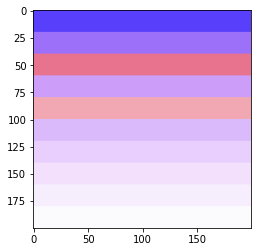

In [755]:
clusters_img = np.ones([20*N_CLUSTERS,20*N_CLUSTERS,3])
for i in range(N_CLUSTERS):
    begin = i*20
    end = (i+1)*20
    clusters_img[begin:end,:] = clusters_rgb[i]
plt.imshow(clusters_img)

In [756]:
x = [colorfulness(*color) for color in clusters_rgb]
x.sort()
x

[0.0029438726373062197,
 0.015422987309905226,
 0.031122291289121383,
 0.04876786518584185,
 0.06942401336220447,
 0.0920573378669156,
 0.09718977972355587,
 0.1420619135043267,
 0.14454528743994707,
 0.20961547448758855]